<small>
Copyright (C) 2025, École Polytechnique Fédérale de Lausanne. All Rights Reserved.
</small>

---

# Model Predictive Control: Exercise 1

Consider the discrete-time LTI system defined by
$$
\begin{align*}
x_{i+1} &= Ax_i + Bu_i \\
y_i &= Cx_i
\end{align*}
$$
with
$$
A = \begin{bmatrix}
4/3 & -2/3 \\
1 & 0
\end{bmatrix}, \quad
B = \begin{bmatrix}
1 \\
0
\end{bmatrix}, \quad
C = \begin{bmatrix}
-2/3 & 1
\end{bmatrix}
$$

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# System dynamics
nx = 2
nu = 1
A = np.array([[4 / 3, -2 / 3], [1, 0]])
B = np.array([[1], [0]])
C = np.array([[-2 / 3, 1]])

Throughout this notebook, you will mainly use `numpy` and `matplolib`. If you are not familiar with these libraries, we encourage you to check out some basic guides such as the following ones:
- [NumPy for Matlab users](https://numpy.org/doc/stable/user/numpy-for-matlab-users.html): a good starting point for people familiar with Matlab. You will see that NumPy and Matlab resemble each other but do have some differences.
- [NumPy fundamentals](https://numpy.org/doc/stable/user/basics.html): a more exhaustive guide that can be a useful resource beyond this course. You should not feel obligated to read all of it at once. We recommend rather going there to complement your knowledge on a specific topic when you need it.
- [Basic Matplotlib](https://www.w3schools.com/python/matplotlib_intro.asp): simple examples to show you the basic functionality of Matplotlib. If you are used to Matlab plotting

Note that all the functions you should need are already imported at the beginning of this notebook, you can use them directly.

## Problem 1: Bellman recursion

Consider the optimal control law minimizing the cost
$$ V = \sum_{i=0}^{N-1} (x_i^T Q x_i + u_i^T R u_i) + x_N^T P_f x_N$$
with 
$$ Q = C^T C + 0.001 I_{2\times 2}, \quad R = 0.001, \quad P_f = Q\,.$$

### Task 1

Use the discrete-time Bellman recursion to define a function `bellman` that takes as input an integer `N` and outputs a list of arrays `Klist` containing the linear feedback gains to be applied at each stage `i` in the finite horizon.

> _Hint_: You can use the function `np.linalg.solve` to solve a linear system, the same way you would use `\` in Matlab.

In [11]:
Q = C.T @ C + 0.001 * np.eye(2)
R = np.array([[0.001]])

In [12]:
def bellman(N: int)-> list[np.ndarray]:
    # TODO: implement the Bellman recursion here
    Klist = []
    Hlist = []
    Hlist.append(Q)
    for k in range(N-1, -1, -1):
        # K_k = -1/(R + B.T @ Hlist[k+1] @ B) * A.T @ Hlist[k+1] @ B -> the multplicaiton works in our case because m = 1 (number of inputs)
        # In matlab, would be : K_k = - (R + B' * Hlist{k+1} * B) \ (A' * Hlist{k+1} * B) = P\Q = inv(P)*Q (but is not recommended to use inv)
        # In Python, P\Q replaced by np.linalg.solve(P, Q) to solve P*x = Q i.e. x = inv(P)*Q
        K_k = -1/(R + B.T @ Hlist[-1] @ B) * B.T @ Hlist[-1] @ A
        Klist.append(K_k)

        H_k = Q + A.T @ Hlist[-1] @ A - 1/(R+B.T @ Hlist[-1] @ B) * (A.T @ Hlist[-1] @ B @ B.T @ Hlist[-1] @ A)
        Hlist.append(H_k)

    Klist = Klist[::-1]
    return Klist

# IMPORTANT REMARK : much faster to use clsed-form solution given at slides 33 - 36 of chapter 1  

# Problem 2: Receding horizon control

### Task 1

Compute the open-loop prediction given by the optimal control law computed you computed above at the state $x=[10, 10]^T$. Compute the closed-loop state trajectory over 20 time steps, starting from the same initial state. 

In [13]:
# Initial condition
x0 = np.array([[10], [10]])

# Control gains
N = 10 # TODO: choose a horizon length
Klist = bellman(N)

# Open-loop prediction
x_ol = [x0] # TODO: construct the list of states for the open-loop predictions using a for loop
for k in range(N):
    u_k = Klist[k] @ x_ol[-1]
    x_next = A @ x_ol[-1] + B @ u_k
    x_ol.append(x_next)

# Closed-loop control simulation
K = Klist[0]
# Checking if CL system is stable
if np.max(np.abs(np.linalg.eigvals(A + B @ K))) > 1:
    raise ValueError("System is unstable! Choose a longer horizon.")
tmax = 20

x_cl = [x0] # TODO: construct the list of states for the closed-loop predictions using a for loop
for t in range(tmax):
    u_t = K @ x_cl[-1]
    x_next = A @ x_cl[-1] + B @ u_t
    x_cl.append(x_next)

### Task 2

Plot side by side the closed-loop trajectory and the open-loop prediction obtained from the first state. 

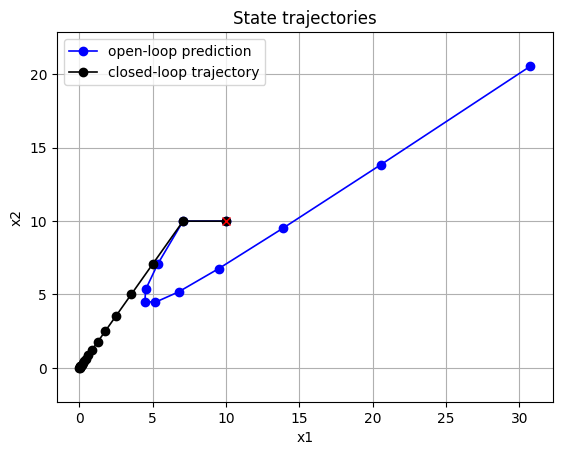

In [14]:
# TODO: plot the open-loop and closed-loop trajectories here
x_ol = np.hstack(x_ol)
x_cl = np.hstack(x_cl)
plt.figure()
plt.plot(x0[0], x0[1], "rx", zorder=10)
# Plot open-loop prediction
plt.plot(x_ol[0, :], x_ol[1, :], "b-o", linewidth=1.2, label="open-loop prediction")
# Plot closed-loop trajectory
plt.plot(x_cl[0, :], x_cl[1, :], "k-o", linewidth=1.2, label="closed-loop trajectory")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('State trajectories')
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

> **NOTE**:
> In the following three tasks, you should only modify some values in the code above, observe the results and make conclusions.

Note Vincent : N is the horizon used to compute the gains K_k, and thus K_0. So Even if changing N can thus change K_0, the closed loop system will evolve using tmax = 20 as we set that we want to use 20 time stamps for the closed loop system (so there will be 20 different segments to the trajectory, computed in part using K_0 which, in CL, does not change with the time stamps, unlike in OL). But of course, the number of segments for the open loop trajectory is equal to N per definition.

### Task 3

Use the code for the previous two questions to find the minimum horizon length $N^*$ that stabilizes the system.

Response : $N^* = 7$. For less, the CL is unstable. For $N\geq7$, the CL is stable, but the smaller N, the worse is the OL state trajectory : it diverges and doesn't reach the equilibrium at the origin.
### Task 4

Motivate why increasing the horizon stablizes the closed-loop system.

Increasing the prediction horizon allows the MPC (finite-horizon LQR) to account for longer-term effects of its control actions (see slides 39 - 47 of chapter 1). It is as if the system had exact knowledge of all its surroundings and of the future, such that it could predict exactly and at the very initial state what to do to converge to the equilibrium. This prediction then does not need to be updated in the future, as the trajectory computed at the initial state already knew all which was to be found later on that could influence the trajectory.

### Task 5

Given a horizon length $N^*$ that stabilizes the closed-loop system, can you be sure that the system will be stable for $N > N^*$?

Yes, because the controller will include all previous costs and an additional one. So it will never be less cautious.

# Problem 3: Linear Quadratic Regulator (LQR)

### Task 1

Implement the infinite horizon LQR controller $u = K_\infty x$.

> _Hint_: You can use the function [`dlqr`](https://python-control.readthedocs.io/en/0.10.2/generated/control.dlqr.html#control.dlqr) from the Python control toolbox (imported above). Note that this function uses a slightly different convention and computes a matrix $K_\infty$ such that the control to apply is $u = -K_\infty x$.

In [26]:
# TODO: your code here
# print(K_inf)
K_inf = - ct.dlqr(A, B, Q, R)[0] # minus to be consistent with our notation
H_inf = ct.dlqr(A, B, Q, R)[1]
print("K_inf = ", K_inf)
print("H_inf = \n", H_inf)

K_inf =  [[-0.6682962  0.6660034]]
H_inf = 
 [[ 1.00412513 -0.6671122 ]
 [-0.6671122   1.001444  ]]


### Task 2

Compare the infinite horizon cost for the system in closed loop with $u = K_\infty x$ and with $u = K_{N^*} x$.

> _Hint_: For the latter, you can approximate the infinite horizon cost numerically using long state and input trajectories:
> $$
> V_\infty = \sum_{k=0}^{\infty} (x_k^T Q x_k + u_k^T R u_k) \approx \sum_{k=0}^{1000} (x_k^T Q x_k + u_k^T R u_k) 
> $$

In [40]:
cost_inf = x0.T @ H_inf @ x0
print("Infinite horizon cost with u = Kinf @ x :", cost_inf)

N_star = 10 # infinite horizon but K_N_star computed with horizon N_star
Klist = bellman(N_star)
K_fin = Klist[0]

cost_fin = 0
x_k = x0
kmax = 1000
for k in range(kmax):
    u_k = K_fin @ x_k
    cost_fin += x_k.T @ Q @ x_k + u_k.T @ R @ u_k
    x_k = A @ x_k + B @ u_k

    


print("Infinite horizon cost with u = K @ x:", cost_fin)

Infinite horizon cost with u = Kinf @ x : [[67.13447333]]
Infinite horizon cost with u = K @ x: [[67.50473303]]
